<a href="https://colab.research.google.com/github/gusujio/neural_networks_start/blob/master/%D0%BF%D0%B5%D1%80%D0%B2%D0%B0%D1%8F_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

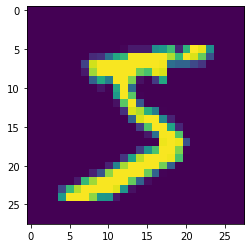


tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Точно так же, как у ЛеКуна, у нас будет первый слой, который принимает один канал на вход, потому что картинка у нас одномерная (там один канал) -- не RGB, а grayscale, и на выходе будет 6 каналов. Сделаем паддинг 2, что бы сохранить размерность 

 Напоминаю, что average pooling не так уж популярны, они используются обычно в конце архитектуры чтобы сжать всё изображение, которое получилось, а в середине сети обычно используется max pooling, но в силу традиций здесь тоже мы используем average pooling 2d. У него "kernel_size" -- 2, потому что это пулинг 2 на 2, и "stride" -- 2, потому что он применяется без пересечений.

In [10]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(#картинка плоская, так что используем 2d 
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh() # тангенс как функция активации 
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # усред
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
#Далее мы растянем изображение в один вектор (это мы делаем в функции "forward",
# а пока мы представим, что мы уже растянули всё изображение в один вектор),
# и далее нам нужно три полносвязанных слоя.

# Первый полносвязанный слой на вход принимает изображение размером 5 на 5 и глубиной 6.
#  Перемножаем 5 на 5 на 6, получаем 400 -- это размер нашего вектора,
#  и на выходе мы хотим вектор размера 120.
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)

# А в функции forward мы повторяем всю эту логику,
#  но теперь применяем эти слои к некоторому входному тензору X.
#  Входной тензор X -- это, на самом деле, батч из картинок. 
# Мы применяем конволюцию, активацию, пулинг, конволюцию, активацию,
#  пулинг
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
# и вот здесь мы растянем наш тензор,
#  который у нас на самом деле четырёхмерный,
#  потому что первая размерность отвечает за размерность батча.
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()        

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [14]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
# Получается, что в loss, на самом деле, хранится не просто число какое-то, 
#  на самом деле хранится весь граф, который нам помогает потом градиенты обсчитать. 
# И после этого нужно ещё её, по-хорошему, отправить на CPU, чтобы она не занимала нам память на GPU
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9761)
tensor(0.9844)
tensor(0.9865)
tensor(0.9879)
tensor(0.9882)
tensor(0.9875)
tensor(0.9889)
tensor(0.9869)
tensor(0.9883)
tensor(0.9882)
tensor(0.9904)
tensor(0.9892)
tensor(0.9880)
tensor(0.9890)
tensor(0.9891)
tensor(0.9878)
tensor(0.9885)
tensor(0.9889)
tensor(0.9888)
tensor(0.9894)
tensor(0.9890)
tensor(0.9880)
tensor(0.9891)
tensor(0.9892)
tensor(0.9903)
tensor(0.9887)
tensor(0.9900)
tensor(0.9875)
tensor(0.9889)
tensor(0.9895)
tensor(0.9888)
tensor(0.9902)
tensor(0.9893)


KeyboardInterrupt: ignored

In [15]:
lenet5.forward(X_test)

tensor([[ -3.6265,   0.2846,  -0.9149,  ...,  17.2244,  -5.3467,   3.9665],
        [  1.5619,   0.0948,  22.1557,  ...,  -3.2812,   2.4409,  -6.6141],
        [ -3.3095,  20.8823,  -0.9146,  ...,   0.6487,  -0.5303,  -3.6535],
        ...,
        [ -5.6904,  -2.0445,  -5.5649,  ...,   2.2038,   1.7474,   3.6327],
        [ -1.5496,  -3.6389,  -8.2197,  ...,  -9.3203,   6.6279,  -3.9051],
        [  4.1760,  -3.3001,   1.3932,  ..., -11.3631,   1.6182,  -7.3954]],
       device='cuda:0', grad_fn=<AddmmBackward>)

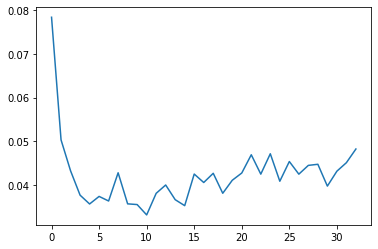

In [16]:
plt.plot(test_loss_history);